# sentinelsat

In [7]:
# see https://sentinelsat.readthedocs.io/en/stable/index.html
# and the Sentinel user guide at https://sentinels.copernicus.eu/web/sentinel/user-guides

!pip install --user sentinelsat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 126.1 MB/s eta 0:00:0000:0100:01
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# connect to the OData API
#
# save credentials for scihub.copernicus.eu in $HOME/.netrc like this:
#
# machine scihub.copernicus.eu
#   login <your username>
#   password <your password>
# machine colhub.met.no
#   login <your username>
#   password <your password>
#
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter

local_api = SentinelAPI(None, None, "https://colhub-archive.met.no")
api = SentinelAPI(None, None, "https://scihub.copernicus.eu/dhus")

data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/"

In [2]:
# get full metadata for a specific product
api.get_product_odata('04548172-c64a-418f-8e83-7a4d148adf1e', full=True)

{'id': '04548172-c64a-418f-8e83-7a4d148adf1e',
 'title': 'S1A_IW_SLC__1SDV_20170425T155612_20170425T155639_016302_01AF91_46FF',
 'size': 4633501134,
 'md5': 'e5855d1c974171d33ee4bc08b9d221ae',
 'date': datetime.datetime(2017, 4, 25, 15, 56, 12, 814000),
 'footprint': 'POLYGON((34.322010 0.401648,36.540989 0.876987,36.884121 -0.747357,34.664474 -1.227940,34.322010 0.401648))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('04548172-c64a-418f-8e83-7a4d148adf1e')/$value",
 'Online': False,
 'Creation Date': datetime.datetime(2017, 4, 25, 19, 22, 0, 383000),
 'Ingestion Date': datetime.datetime(2017, 4, 25, 19, 23, 45, 956000),
 'Acquisition Type': 'NOMINAL',
 'Carrier rocket': 'Soyuz',
 'Cycle number': 107,
 'Date': datetime.datetime(2017, 4, 25, 15, 56, 12, 814000),
 'Filename': 'S1A_IW_SLC__1SDV_20170425T155612_20170425T155639_016302_01AF91_46FF.SAFE',
 'Footprint': '<gml:Polygon srsName="http://www.opengis.net/gml/srs/epsg.xml#4326" xmlns:gml="http://www.opengis.net/gml"

In [3]:
# NOTE: Test data - overwritten by next cell

# Spatial locations
locations = [[4.4, 60.3],
             [3.4, 60.3],
             [3.4, 65.7]]

footprint_json = {
  "type": "Feature",
  "geometry": {
    "type": "MultiPoint",
    "coordinates": locations
  }
}
footprint = geojson_to_wkt(footprint_json)

# Time interval
start_times = "2022-09-25T00:00:00.000Z"
end_times = "2022-09-26T23:59:59.000Z"

In [4]:
# import dict containing metadata for in-situ data
# https://raw.githubusercontent.com/jerabaul29/MachineOcean_WP1_WHOI/main/mo_whoi_data/data_files/in_situ_dict.py
# from private repo at https://github.com/jerabaul29/MachineOcean_WP1_WHOI
import time
import os

os.environ["TZ"] = "UTC"
time.tzset()

import datetime
import pytz

utc_timezone = pytz.timezone("UTC")

import sys
sys.path.append("../../MachineOcean_WP1_WHOI/mo_whoi_data/data_files")

import in_situ_dict
in_situ_obs = in_situ_dict.get_in_situ_metadata()

# make list of in-situ locations to fetch sat data for, including start_time and end_time for each location timeseries
locations = []
start_times = []
end_times = []

for obs in in_situ_obs.values():
    locations.append([obs["lon"][0], obs["lat"][0]])
    start_times.append(obs["datetime_start"])
    end_times.append(obs["datetime_end"])

In [6]:
# search by polygon, time, and SciHub query keywords - build dict with all relevant sat products
products_colhub = {}
products_scihub = {}
for (location, start_time, end_time) in zip(locations, start_times, end_times):
    footprint_json = {
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": location
      }
    }
    footprint = geojson_to_wkt(footprint_json)

    products_colhub.update(local_api.query(footprint,
                        date=(start_time, end_time),
                        platformname="Sentinel-1",
                        producttype="GRD"))
                        #limit=1,
                        #cloudcoverpercentage=(0, 30)))

    products_scihub.update(api.query(footprint,
                        date=(start_time, end_time),
                        platformname="Sentinel-1",
                        producttype="GRD"))
                        #limit=1,
                        #cloudcoverpercentage=(0, 30)))

print("Sat products available on colhub.met.no: " + str(len(products_colhub)))

print("Sat products available on scihub.copernicus.eu/dhus: " + str(len(products_scihub)))


# are the products online or offline?
online = 0
offline = 0
#for product_id in list(products_scihub.keys()):
#    if api.is_online(product_id):
#        #print("Product {} is online. Will download.".format(product_id))
#        
#        online += 1
#    else:
#        #print("Product {} is offline. Will NOT download.".format(product_id))
#        #del products[product_id]
#        
#        #print(("Product {} is offline. Retrieval is triggered.".format(product_id))
#        #api.trigger_offline_retrieval(product_id)
#        offline += 1
#
#print("{} online products and {} offline products available on scihub.".format(online, offline))

Querying products:  25%|##5       | 100/396 [00:00<?, ?product/s]

Querying products:  30%|###       | 100/331 [00:00<?, ?product/s]

Sat products available on colhub.met.no: 0
Sat products available on scihub.copernicus.eu/dhus: 937


From https://forum.step.esa.int/t/esa-copernicus-data-access-long-term-archive-and-its-drawbacks/15394 

[…] you try an bypass the quota restrictions by using multiple user accounts to access large volumes of data products from the LTA. Please note that the maximum number of products that a single user can request on SciHub is 1 every 30 minutes. An additional quota limit is applied to users of the APIHub of maximum 20 products every 12 hours. These restrictions are dictated by ESA and unless they change their policy then users will have to follow these guidelines. […]

Base on the long time archive (LTA) quota: 1000 products / 40 products per day = 25 days (not taking download time into account)

In [10]:
#path_filter = make_path_filter("*s1?-*-grd-vv-*.tiff") # all Sentinel 1 GRD products with vv polarization
path_filter = make_path_filter("*s1?-*-grd-*.tiff") # all Sentinel 1 GRD products
###api.download_all(products_scihub, directory_path=data_dir)#, nodefilter=path_filter)

# convert to Pandas DataFrame
products_df = api.to_dataframe(products_scihub)

# GeoJSON FeatureCollection containing footprints and metadata of the scenes
products_geojson = api.to_geojson(products_scihub)

# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
products_gdf = api.to_geodataframe(products_scihub)

# Get basic information about the product: its title, file size, MD5 sum, date, footprint and
# its download url
#api.get_product_odata(<product_id>)

# Get the product's full metadata available on the server
#api.get_product_odata(<product_id>, full=True)

# TODO: Sort products based on which in-situ obs ts they are have a colocation with and start product retrieval and downloading

In [8]:
products_gdf

,title,link,link_alternative,link_icon,summary,ondemand,ingestiondate,beginposition,endposition,missiondatatakeid,...,polarisationmode,productclass,producttype,platformname,size,status,uuid,processed,timeliness,geometry
ba781da2-8040-412f-a9b2-60215b5e45e1,S1A_IW_GRDH_1SDV_20151015T104915_20151015T1049...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2015-10-15T10:49:15.784Z, Instrument: SA...",false,2015-10-15 13:50:00.722,2015-10-15 10:49:15.784,2015-10-15 10:49:41.338,46959,...,VV VH,S,GRD,Sentinel-1,1.61 GB,ARCHIVED,ba781da2-8040-412f-a9b2-60215b5e45e1,NaN,NaN,"POLYGON ((-69.84327 39.37832, -72.74277 39.771..."
4cd3b915-769e-4bcb-9755-e2ba5d27d35e,S1A_IW_GRDH_1SDV_20151003T104915_20151003T1049...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2015-10-03T10:49:15.647Z, Instrument: SA...",false,2015-10-03 13:50:04.049,2015-10-03 10:49:15.647,2015-10-03 10:49:41.185,45758,...,VV VH,S,GRD,Sentinel-1,1.61 GB,ARCHIVED,4cd3b915-769e-4bcb-9755-e2ba5d27d35e,NaN,NaN,"POLYGON ((-69.84244 39.37930, -72.74186 39.772..."
51ab49e6-d511-418f-8f16-8fecfa14a6e4,S1A_IW_GRDH_1SDV_20150921T104915_20150921T1049...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2015-09-21T10:49:15.4Z, Instrument: SAR-...",false,2015-09-21 14:18:47.722,2015-09-21 10:49:15.400,2015-09-21 10:49:40.932,44539,...,VV VH,S,GRD,Sentinel-1,1 GB,ARCHIVED,51ab49e6-d511-418f-8f16-8fecfa14a6e4,NaN,NaN,"POLYGON ((-69.84261 39.37970, -72.74193 39.772..."
c8a84b40-a72b-4b2a-bd2d-6212acb70d17,S1A_IW_GRDH_1SDV_20150909T104915_20150909T1049...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2015-09-09T10:49:15.104Z, Instrument: SA...",false,2015-09-09 13:43:19.067,2015-09-09 10:49:15.104,2015-09-09 10:49:40.655,43365,...,VV VH,S,GRD,Sentinel-1,1 GB,ARCHIVED,c8a84b40-a72b-4b2a-bd2d-6212acb70d17,NaN,NaN,"POLYGON ((-69.84345 39.37860, -72.74261 39.771..."
1f6b33ba-a1c7-424c-b74e-db9ff91280d4,S1A_IW_GRDH_1SDV_20150828T104914_20150828T1049...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2015-08-28T10:49:14.659Z, Instrument: SA...",false,2015-08-28 16:21:54.657,2015-08-28 10:49:14.659,2015-08-28 10:49:40.209,42133,...,VV VH,S,GRD,Sentinel-1,1 GB,ARCHIVED,1f6b33ba-a1c7-424c-b74e-db9ff91280d4,NaN,NaN,"POLYGON ((-69.84425 39.37872, -72.74355 39.771..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0391e12f-eb80-419e-ae28-4a0bff6cb192,S1B_EW_GRDM_1SDH_20190808T201111_20190808T2012...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-08-08T20:11:11.827Z, Instrument: SA...",false,2019-08-09 13:56:39.427,2019-08-08 20:11:11.827,2019-08-08 20:12:11.822,134797,...,HH HV,S,GRD,Sentinel-1,405.97 MB,ARCHIVED,0391e12f-eb80-419e-ae28-4a0bff6cb192,NaN,Fast-24h,"MULTIPOLYGON (((-42.45735 58.92859, -35.27452 ..."
c1f9cab6-f3a6-47a4-b641-861698737a85,S1B_IW_GRDH_1SDH_20190808T085637_20190808T0857...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-08-08T08:56:37.937Z, Instrument: SA...",false,2019-08-08 12:04:55.061,2019-08-08 08:56:37.937,2019-08-08 08:57:02.937,134739,...,HH HV,S,GRD,Sentinel-1,1.58 GB,ARCHIVED,c1f9cab6-f3a6-47a4-b641-861698737a85,NaN,Fast-24h,"MULTIPOLYGON (((-37.09840 58.58822, -36.44814 ..."
a724a84d-d768-4e59-b6f6-361a4f1f14c6,S1A_EW_GRDM_1SDH_20190807T201927_20190807T2020...,ht

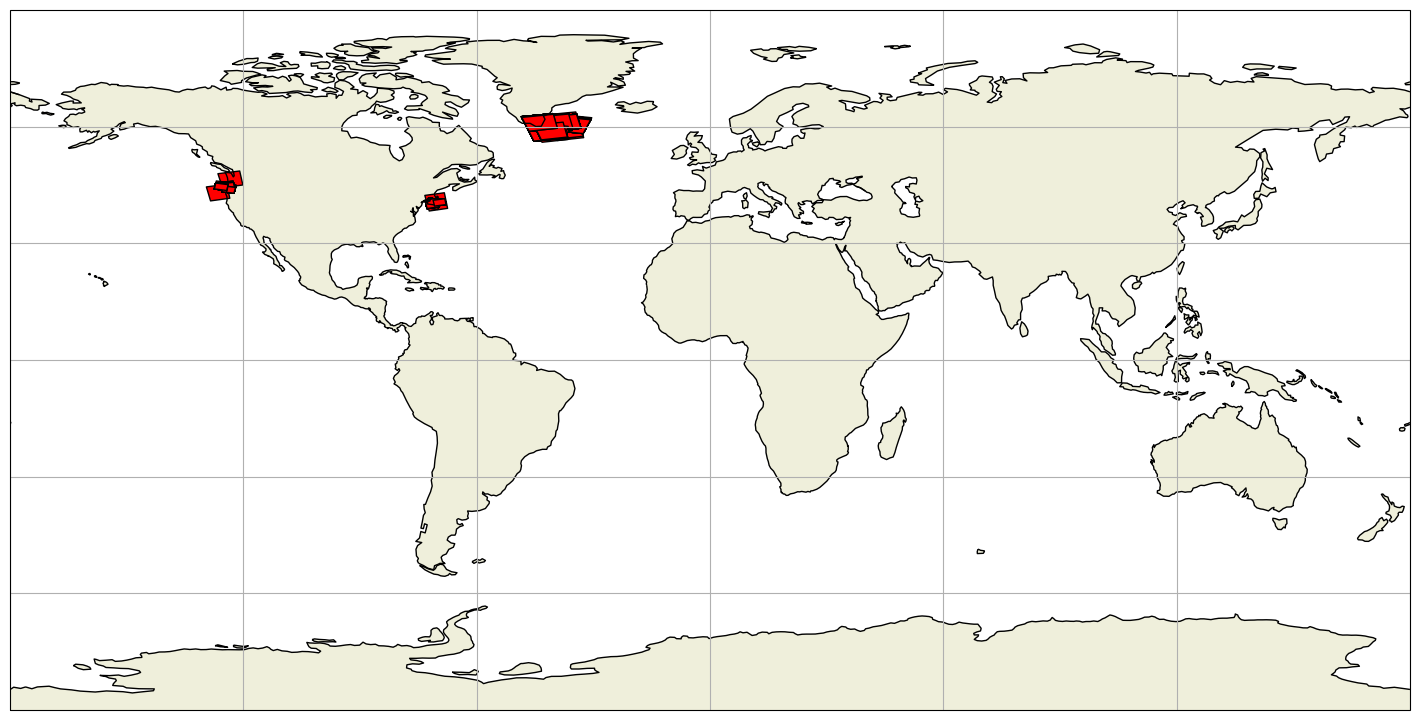

In [9]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import numpy as np

fig = plt.figure(figsize=(20, 20))

bounds = products_gdf.total_bounds

ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

#ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
#ax2.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
#ax2.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.COASTLINE)
#
#locations_np = np.array(locations)
#locs_x, locs_y = locations_np.T
#ax2.scatter(locs_x, locs_y, transform=ccrs.PlateCarree(), zorder=2)

plt.show()

# pytroll

## NOTE: We have decided to go for nansat, so the following "code experiments" are no longer relevant.

In [2]:
# see http://pytroll.github.io/

!pip install --user satpy rioxarray rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 113.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 26.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
  Created wheel for satpy: filename=satpy-0.37.1-py2.py3-none-any.whl size=1308928 sha256=21b6993ee16ac37dea8383ffa54426f1e3eff2efef6b0c968ec4ea

In [3]:
from satpy.utils import check_satpy

check_satpy()

Readers
abi_l1b:  ok
abi_l1b_scmi:  ok
abi_l2_nc:  ok
acspo:  ok
agri_l1:  ok
ahi_hrit:  ok
ahi_hsd:  ok
ahi_l1b_gridded_bin:  ok
ami_l1b:  cannot find module 'satpy.readers.ami_l1b' (No module named 'pyspectral')
amsr2_l1b:  ok
amsr2_l2:  ok
amsr2_l2_gaasp:  ok
amsub_l1c_aapp:  ok
ascat_l2_soilmoisture_bufr:  ok
avhrr_l1b_aapp:  ok
avhrr_l1b_eps:  ok
avhrr_l1b_gaclac:  cannot find module 'satpy.readers.avhrr_l1b_gaclac' (No module named 'pygac')
avhrr_l1b_hrpt:  cannot find module 'satpy.readers.hrpt' (No module named 'geotiepoints')
avhrr_l1c_eum_gac_fdr_nc:  ok
caliop_l2_cloud:  cannot find module 'satpy.readers.caliop_l2_cloud' (No module named 'pyhdf')
clavrx:  cannot find module 'satpy.readers.clavrx' (No module named 'pyhdf')
cmsaf-claas2_l2_nc:  ok
electrol_hrit:  ok
fci_l1c_nc:  ok
fci_l2_nc:  ok
generic_image:  ok
geocat:  ok
ghrsst_l2:  ok
glm_l2:  ok
goes-imager_hrit:  ok
goes-imager_nc:  ok
gpm_imerg:  ok
grib:  ok
hsaf_grib:  ok
hy2_scat_l2b_h5:  ok
iasi_l2:  ok
iasi_l2_s

In [15]:
from satpy import Scene, find_files_and_readers
from datetime import datetime
import zipfile
from os import path
import glob

for product_name in products_gdf.title:
    zip_filename = data_dir + "{}.zip".format(product_name)
    safe_dir_name = data_dir + "{}.SAFE".format(product_name)

    if not path.exists(safe_dir_name):
        with zipfile.ZipFile(zip_filename,"r") as zip_ref:
            zip_ref.extractall(data_dir)

In [27]:
import os
print(os.listdir(data_dir + "S1A_IW_SLC__1SDV_20220925T171245_20220925T171312_045164_0565E1_37BD.SAFE"))

files = find_files_and_readers(
    base_dir=data_dir + "S1A_IW_SLC__1SDV_20220925T171245_20220925T171312_045164_0565E1_37BD.SAFE",
    reader="sar-c_safe")

['S1A_IW_SLC__1SDV_20220925T171245_20220925T171312_045164_0565E1_37BD.SAFE-report-20220925T180337.pdf', 'preview', 'support', 'manifest.safe', 'measurement', 'annotation']


ValueError: No supported files found

In [17]:
from satpy.dataset import DataQuery

scn = Scene(filenames=files)

scn.available_dataset_names()
scn.available_composite_names()

['sar-ice',
 'sar-ice-iw',
 'sar-ice-legacy',
 'sar-ice-log',
 'sar-ice-log-iw',
 'sar-land',
 'sar-land-iw',
 'sar-quick',
 'sar-rgb']

In [14]:
vh_id = DataQuery(name="measurement", polarization="vh")
scn.load([vh_id])
scn[vh_id]

ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found


<xarray.DataArray (y: 16678, x: 26733)>
dask.array<clip, shape=(16678, 26733), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) int64 0 1 2 3 4 5 6 ... 16672 16673 16674 16675 16676 16677
  * x            (x) int64 0 1 2 3 4 5 6 ... 26727 26728 26729 26730 26731 26732
    band         int64 1
    spatial_ref  int64 0
    crs          object +proj=latlong +datum=WGS84 +ellps=WGS84 +type=crs
Attributes:
    name:                 measurement
    sensor:               sar-c
    wavelength:           [5.4, 5.405, 5.41]
    resolution:           80
    polarization:         vh
    calibration:          gamma
    quantity:             natural
    coordinates:          ('longitude', 'latitude')
    file_type:            safe_measurement
    standard_name:        backscatter
    units:                1
    modifiers:            ()
    platform_name:        s1b
    start_time:           2021-12-15 06:10:27
    end_time:             2021-12-15 06:10:52
    reader:               sar-c_safe
    area:                 Shape: (16678, 26733)\nLons: <xarray.DataArray 'int...
    _satpy_id:            DataID(name='measurement', polarization='vh', resol...
    ancillary_variables:  []

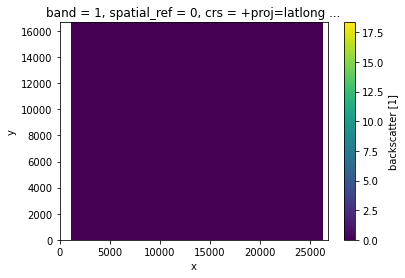

In [16]:
# To save as Geotiff (including the GCPs):
#scn.save_dataset(vh_id)

# XXX: Takes forever... investigate further
scn[vh_id].plot.imshow()

# XXX: Check out https://python-kurs.github.io/sommersemester_2019/units/S01E06.html 
# and https://nbviewer.org/github/pytroll/pytroll-examples/ ?